In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/cleaned.csv')

df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

In [3]:
reference_date = df['Order Date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (reference_date - x.max()).days,  # Recency
    'Order ID': 'count',                                      # Frequency
    'Sales': 'sum'                                           # Monetary
}).rename(columns={
    'Order Date': 'Recency',
    'Order ID': 'Frequency', 
    'Sales': 'Monetary'
})

print(rfm.describe())
rfm.head()

           Recency   Frequency     Monetary
count   793.000000  793.000000   793.000000
mean    149.616646   12.203026  2215.141706
std     187.102142    6.079473  1518.088066
min       1.000000    1.000000     4.833000
25%      31.000000    8.000000  1031.602000
50%      77.000000   11.000000  1936.640000
75%     185.000000   16.000000  3082.653000
max    1166.000000   35.000000  8331.986000


,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,185,10,1633.488
AA-10375,20,15,1056.390
AA-10480,260,12,1790.512
AA-10645,56,18,5086.935
AB-10015,416,6,886.156


In [4]:
def detect_outliers_iqr(df, columns):
    outliers_indices = set()
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Find outliers
        column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        outliers_indices.update(column_outliers)
    
    return list(outliers_indices)

outlier_indices = detect_outliers_iqr(rfm, ['Recency', 'Frequency', 'Monetary'])

rfm_clean = rfm.drop(outlier_indices)
rfm = rfm_clean

In [5]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)

print("Scaled RFM data:")
print(rfm_scaled_df.describe())
rfm_scaled_df.head()

Scaled RFM data:
            Recency     Frequency      Monetary
count  7.010000e+02  7.010000e+02  7.010000e+02
mean   8.362308e-17 -1.267016e-16 -2.027226e-16
std    1.000714e+00  1.000714e+00  1.000714e+00
min   -9.988384e-01 -2.050885e+00 -1.595131e+00
25%   -7.142659e-01 -7.765159e-01 -8.028672e-01
50%   -3.806292e-01 -4.830500e-02 -1.466800e-01
75%    3.160828e-01  6.799059e-01  6.348047e-01
max    3.073492e+00  2.864539e+00  2.876803e+00


,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,0.806725,-0.412410,-0.406992
AA-10375,-0.812394,0.497853,-0.827998
AA-10480,1.542688,-0.048305,-0.292440
AA-10645,-0.459132,1.044011,2.112372
AB-10015,3.073492,-1.140621,-0.952187


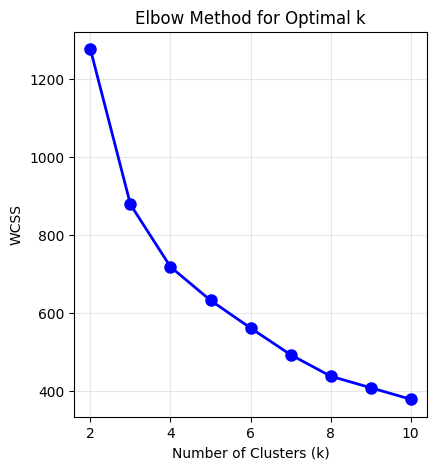

In [6]:
k_range = range(2, 11)
wcss = []  # Within-cluster sum of squares

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

k=2: Silhouette Score = 0.353
k=3: Silhouette Score = 0.375
k=4: Silhouette Score = 0.314
k=5: Silhouette Score = 0.306
k=6: Silhouette Score = 0.304
k=7: Silhouette Score = 0.288
k=8: Silhouette Score = 0.296
k=9: Silhouette Score = 0.268
k=10: Silhouette Score = 0.276

Suggested k by silhouette analysis: 3


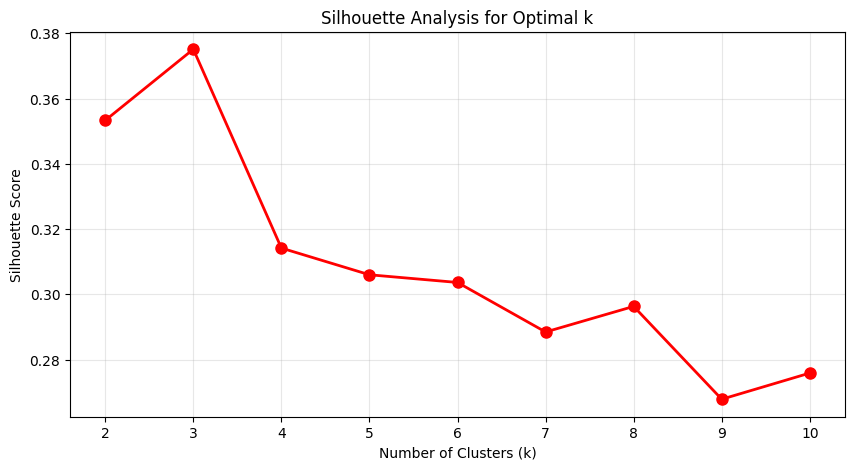

In [7]:
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: Silhouette Score = {silhouette_avg:.3f}")

optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]

plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.grid(True, alpha=0.3)

print(f"\nSuggested k by silhouette analysis: {optimal_k_silhouette}")
plt.show()

In [8]:
final_k = optimal_k_silhouette

# Perform final K-means clustering
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(rfm_scaled)

# Add cluster labels to original RFM data
rfm['Cluster'] = clusters

print(f"\nCluster distribution:")
print(rfm['Cluster'].value_counts().sort_index())
print(f"\nFinal silhouette score: {silhouette_score(rfm_scaled, clusters):.3f}")


Cluster distribution:
Cluster
0    261
1    113
2    327
Name: count, dtype: int64

Final silhouette score: 0.375


In [9]:
# Analyze cluster characteristics
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median']
}).round(2)

cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns]

print("Cluster Characteristics:")
print(cluster_summary)

# Calculate cluster sizes
cluster_sizes = rfm['Cluster'].value_counts().sort_index()
print(f"\nCluster Sizes:")
for cluster, size in cluster_sizes.items():
    percentage = (size / len(rfm)) * 100
    print(f"Cluster {cluster}: {size} customers ({percentage:.1f}%)")


Cluster Characteristics:
         Recency_mean  Recency_median  Frequency_mean  Frequency_median  \
Cluster                                                                   
0               69.53            49.0           17.38              17.0   
1              291.10           283.0            9.43               9.0   
2               64.26            55.0            9.17               9.0   

         Monetary_mean  Monetary_median  
Cluster                                  
0              3542.03          3336.17  
1              1476.74          1405.40  
2              1360.29          1256.94  

Cluster Sizes:
Cluster 0: 261 customers (37.2%)
Cluster 1: 113 customers (16.1%)
Cluster 2: 327 customers (46.6%)


In [10]:
# Interpret clusters with business-friendly labels
def interpret_cluster(cluster_data):
    interpretations = {}
    
    for cluster in cluster_data.index:
        if cluster == 2:
            label = "Low-Value Dormant Customerss"
            description = "Low-Value and inactive customers"
        elif cluster == 1:
            label = "Low-Value Lost Customers"
            description = "Low-value and churned customers"
        else:
            label = "High-Value Dormant Customers"
            description = "High-value but inactive customers"
        
        interpretations[cluster] = {'label': label, 'description': description}
    
    return interpretations

# Get cluster interpretations
cluster_interpretations = interpret_cluster(cluster_summary)

print("CUSTOMER SEGMENT INSIGHTS:")
print("=" * 50)
for cluster in sorted(cluster_interpretations.keys()):
    info = cluster_interpretations[cluster]
    size = cluster_sizes[cluster]
    pct = (size / len(rfm)) * 100
    
    print(f"\nCluster {cluster}: {info['label']}")
    print(f"Description: {info['description']}")
    print(f"Size: {size} customers ({pct:.1f}%)")
    print(f"Avg Recency: {cluster_summary.loc[cluster, 'Recency_mean']:.1f} days")
    print(f"Avg Frequency: {cluster_summary.loc[cluster, 'Frequency_mean']:.1f} orders")
    print(f"Avg Monetary: ${cluster_summary.loc[cluster, 'Monetary_mean']:.2f}")
    print("-" * 40)

CUSTOMER SEGMENT INSIGHTS:

Cluster 0: High-Value Dormant Customers
Description: High-value but inactive customers
Size: 261 customers (37.2%)
Avg Recency: 69.5 days
Avg Frequency: 17.4 orders
Avg Monetary: $3542.03
----------------------------------------

Cluster 1: Low-Value Lost Customers
Description: Low-value and churned customers
Size: 113 customers (16.1%)
Avg Recency: 291.1 days
Avg Frequency: 9.4 orders
Avg Monetary: $1476.74
----------------------------------------

Cluster 2: Low-Value Dormant Customerss
Description: Low-Value and inactive customers
Size: 327 customers (46.6%)
Avg Recency: 64.3 days
Avg Frequency: 9.2 orders
Avg Monetary: $1360.29
----------------------------------------
